# Modele de classification multiple

Dans ce second modèle, nous avons continué de nous intéresser uniquement à la classification, mais en généralisant l'approche mono-forme du modèle 1 à une classification multi-formes, permettant ainsi de prédire plusieurs formes pour une seule image. 
L'approche est très similaire, nous nous appuyons à nouveau sur l'augmentation de données et un VGG19 préentraîné, sur lequel nous defreezons quelques couches.


In [16]:
#Importation des packages nécessaires
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
import tensorflow as tf
import os
import pandas as pd

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import applications
from keras import optimizers
from keras.applications import VGG19
from keras.models import Model
from sklearn import metrics
import itertools
from keras import layers

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras import backend
from tensorflow.keras import callbacks
from tensorflow.keras import initializers

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Préparation & augmentation  des données, séparation données entraînement et validation

In [2]:
import pandas as pd
df_train = pd.read_csv('train.csv')
# ajout de deux colonnes pour imageId et Label de forme
split = df_train["Image_Label"].str.split("_", n = 1, expand = True)
df_train['ImageId'] = split[0]
df_train['Label'] = split[1]
df_train.head()
# création des colonnes indicatrices pour les formes, par dichotomie.
df_corr =  pd.get_dummies(df_train, columns = ['Label'])
# on suppprime les lignes ne contenant pas de forme
df_corr = df_corr.dropna(how = 'any', axis = 0)
# on droppe les colonnes inutiles
df_corr = df_corr.drop(['Image_Label', 'EncodedPixels'], axis = 1)
# on regroupe par ImageId, et on prend le max pour chacun des labels
df_corr = df_corr.groupby('ImageId').max()
# on ajoute finalement une colonne contenant le nombre de formes par image
df_corr['nb_formes'] = df_corr.sum(axis = 1)
print(df_corr.shape)
df_corr.head(5)

(5546, 5)


,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar,nb_formes
ImageId,,,,,
0011165.jpg,1,1,0,0,2
002be4f.jpg,1,1,0,1,3
0031ae9.jpg,1,1,0,1,3
0035239.jpg,0,1,1,0,2
003994e.jpg,1,0,1,1,3


In [3]:
# liste des images defectueuses
list_def1 = ['c26c635.jpg','e5f2f24.jpg']
# liste des images avec encodage defectueux
#list_def2 = ['0741fda.jpg','1860780.jpg','2e324d9.jpg','40db224.jpg','4e29ef1.jpg','506e9d9.jpg','7229f89.jpg','8639a89.jpg','888f3b3.jpg',
# '9c103e5.jpg','b30a770.jpg','b5f39d9.jpg','bb81b7b.jpg','c0c8d52.jpg','c3d60e6.jpg','ccafdde.jpg','d7591b4.jpg','d9bc3a5.jpg','ddb9ef1.jpg',
# 'e4e22fd.jpg','f1ddbc8.jpg','f5691a9.jpg']

# suppression des lignes correspondantes
for name in list_def1:
    df_corr =df_corr.drop(df_corr[df_corr.index == name].index)                
#for name in list_def2:
#    df_corr =df_corr.drop(df_corr[df_corr.index == name].index)

print(df_corr.shape)

(5544, 5)


In [4]:
# Constants
image_width = 500
image_height = 500
img_size = 500
channels = 3
batch_size = 32
IMG_SHAPE = 500

Nous allons recharger en mémoire les images réduites en 500 x 500 pour l'entraînement du modèle.

In [5]:
#On va aggréger les différentes formes présentes en une seule colonne 
def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path
def getclass(row):
    if row.Label_Fish == 1:
        return 0
    if row.Label_Flower == 1:
        return 1
    if row.Label_Gravel == 1:
        return 2
    if row.Label_Sugar == 1:
        return 3   
df_data = df_corr
df_data['path'] = df_corr.index.map(modify_path)
df_data = df_data.reset_index()
df_data = df_data.drop(['ImageId','nb_formes'], axis = 1)
print(df_data.shape)
df_data.head()


(5544, 5)


,Label_Fish,Label_Flower,Label_Gravel,Label_Sugar,path
0,1,1,0,0,train_images_500/0011165.jpg
1,1,1,0,1,train_images_500/002be4f.jpg
2,1,1,0,1,train_images_500/0031ae9.jpg
3,0,1,1,0,train_images_500/0035239.jpg
4,1,0,1,1,train_images_500/003994e.jpg


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_data, test_size = 0.2)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import preprocess_input
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range = 10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 0.1,
                                          fill_mode='nearest'
                                         )

test_data_generator = ImageDataGenerator(rescale = 1./255) #

In [8]:
columns = ['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar']

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col = columns,
                                                           class_mode ="raw",
                                                          shuffle = False,
                                                          target_size = (img_size , img_size), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col = columns,
                                                           class_mode ="raw",
                                                          shuffle = False,
                                                          target_size = (img_size , img_size), 
                                                          batch_size = batch_size)

Found 4435 validated image filenames.
Found 1109 validated image filenames.


### Définition, compilation et entraînement du modèle

In [9]:
# Loading Model VGG19
pretrained_model = VGG19(input_shape=(image_height, image_width, channels), include_top=False, weights="imagenet")
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [10]:
# Freezing the layers (a vérifier a valeur 15 ?)
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True

In [11]:
# Modification of pretrained model
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = GlobalMaxPooling2D()(last_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(4, activation='sigmoid')(x)

In [12]:
# Creating a new model
model = Model(pretrained_model.input, x)

In [13]:
#Callbacks
n_epochs = 20
import os
cwd = os.getcwd()
filepath = cwd
from keras.optimizers import Adam
from tensorflow.keras import callbacks

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience=2,
                                         verbose=2,
                                         mode='min')
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 5,
                                         mode = 'min',
                                         restore_best_weights = True) 
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 10 == 0:
        return learning_rate * 0.1
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule = decreasinglrUpdate,
                                              verbose = 1)

checkpoint = callbacks.ModelCheckpoint(filepath = "weightsTRYVGG19.best.hdf5", 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
#loss=binary_crossentropy

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)    

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=n_epochs,
    validation_data=test_generator,
    #validation_steps=n_validation_samples//batch_size,
    #steps_per_epoch=n_training_samples//batch_size,
    callbacks = [lrScheduler, early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
139/139 [==============================] - 259s 2s/step - loss: 0.7137 - accuracy: 0.5550 - val_loss: 0.6399 - val_accuracy: 0.6312
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
139/139 [==============================] - 251s 2s/step - loss: 0.6306 - accuracy: 0.6343 - val_loss: 0.6162 - val_accuracy: 0.6828
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
139/139 [==============================] - 252s 2s/step - loss: 0.5909 - accuracy: 0.6749 - val_loss: 0.6188 - val_accuracy: 0.7059
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
139/139 [==============================] - 252s 2s/step - loss: 0.5678 - accuracy: 0.6989 - val_loss: 0.6013 - val_accuracy: 0.7138
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 9.9999997473787

### Performance du modèle

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20) # fonction pour récupérer le nbre d'epochs ?

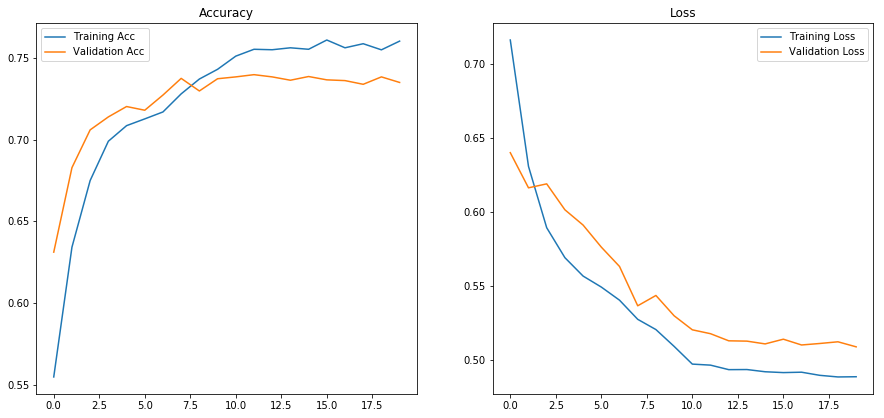

In [60]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend()
plt.title('Accuracy')


plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [63]:
from sklearn.metrics import classification_report
y_pred = model.predict_generator(test_generator)
print(y_pred)
#y_pred_class = y_pred.argmax(axis = 1)
#print(type(y_pred_class))
#y_test_class = X_test['class'].to_numpy(dtype = 'int')
#print(y_test_class)
#print(classification_report(y_test_class, y_pred_class, target_names = ['FISH','FLOWER','GRAVEL','SUGAR']))

[[0.5959144  0.20161971 0.78454316 0.77737457]
 [0.20219031 0.09297463 0.8841634  0.9318603 ]
 [0.789599   0.48132765 0.33870047 0.66019034]
 ...
 [0.45138258 0.35484573 0.42620185 0.8604527 ]
 [0.242865   0.13254622 0.7957729  0.9316901 ]
 [0.2725998  0.96941257 0.17536318 0.2997281 ]]


In [72]:
y_pred_class = (y_pred > 0.5).astype(int)
results=pd.DataFrame(y_pred_class, columns=columns)
#results["Filenames"]=test_generator.path
X_test_class = X_test.drop(['path'], axis = 1)
y_test_class = X_test_class.to_numpy(dtype = 'int')
#print(y_pred_class)
#print(y_test_class)
print(classification_report(y_test_class, y_pred_class, target_names = ['FISH','FLOWER','GRAVEL','SUGAR']))

              precision    recall  f1-score   support

        FISH       0.74      0.51      0.60       558
      FLOWER       0.83      0.77      0.80       470
      GRAVEL       0.67      0.86      0.75       581
       SUGAR       0.73      0.97      0.83       734

   micro avg       0.73      0.79      0.76      2343
   macro avg       0.74      0.78      0.75      2343
weighted avg       0.74      0.79      0.75      2343
 samples avg       0.75      0.82      0.74      2343



La précision de notre modèle semble correcte, mais il faut remarquer qu'elle est calculée formes par forme. Ainsi une image avec 2 bonnes formes prédites sur 3 contribuera à 2 bonnes prédictions et 1 mauvaise pour nos métriques (et non pas 1 mauvaise, ce qui aurait été le cas si nous avions raisonné en combinaison de formes, et pas forme par forme).

### Sauvegarde du modèle

In [84]:
# serialize model to JSON
model_json = model.to_json()
with open("model2_classi_multi.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2_classi_multi.h5")
print("Saved model to disk")

Saved model to disk
